In [9]:
import os, torch, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

import data

In [12]:
root = "e-commerce-products-images"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = data.get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

1250
70
2223
{'Topwear': 0, 'Bottomwear': 1, 'Watches': 2, 'Socks': 3, 'Shoes': 4, 'Belts': 5, 'Flip Flops': 6, 'Bags': 7, 'Innerwear': 8, 'Sandal': 9, 'Shoe Accessories': 10, 'Fragrance': 11, 'Jewellery': 12, 'Lips': 13, 'Saree': 14, 'Eyewear': 15, 'Nails': 16, 'Scarves': 17, 'Dress': 18, 'Loungewear and Nightwear': 19, 'Wallets': 20, 'Apparel Set': 21, 'Headwear': 22, 'Mufflers': 23, 'Skin Care': 24, 'Makeup': 25, 'Free Gifts': 26, 'Ties': 27, 'Accessories': 28, 'Skin': 29, 'Beauty Accessories': 30, 'Water Bottle': 31, 'Eyes': 32, 'Bath and Body': 33, 'Gloves': 34, 'Sports Accessories': 35, 'Cufflinks': 36, 'Sports Equipment': 37, 'Stoles': 38, 'Hair': 39, 'Perfumes': 40, 'Home Furnishing': 41, 'Umbrellas': 42, 'Wristbands': 43, 'Vouchers': 44}


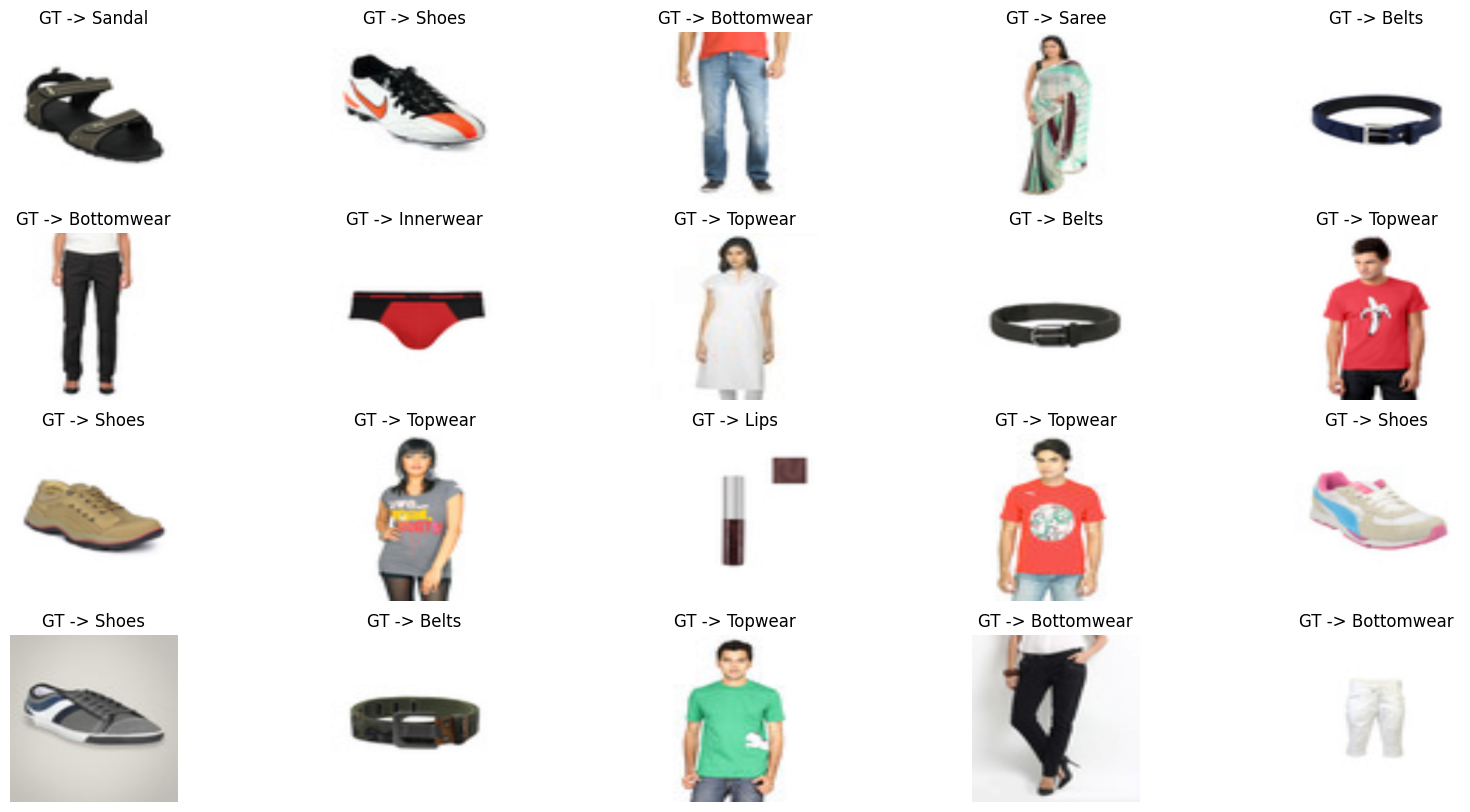

In [13]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))